# Poke the Black Box

A common complaint of some machine learning algorithms is that they are "black boxes", and we have little understanding of the their behavior under the hood.  While this is true for many algorithms, I find that the ease with which we can fit and predict ML models makes it easy to play with inputs and outputs and gain insights into the overall behavior of the model.

This notebook runs through an example of fitting a machine learning model and then playing with input data (i.e., performing counterfactuals) to learn about model performance.  

# Generate Dummy Data
First, let's generate some dummy data.  We will generate hourly power load data, which is dependent on the hour of the day, day of the week, and daily average temperature.  

In [142]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
np.random.seed(42)


In [143]:
def generate_dummy_data(n_weeks=12, start_date='2023-01-01'):
    """
    Generates dummy data with weekly and daily seasonality,
    and temperature-dependent values. Temperatures are in Fahrenheit.
    
    Parameters:
    - n_weeks: int, number of weeks to simulate
    - start_date: str, the date to start the datetime index (format: 'YYYY-MM-DD')
    
    Returns:
    - df: pandas DataFrame with a datetime index, 'value', and 'temperature' columns
    """
    n_days_per_week = 7
    n_hours_per_day = 24
    n_samples = n_weeks * n_days_per_week * n_hours_per_day

    time = np.arange(0, n_samples)

    # Seasonality components
    weekly_cycle = -2 * np.cos(2 * np.pi * time / (7 * n_hours_per_day))
    daily_cycle = -2 * np.cos(2 * np.pi * time / n_hours_per_day)

    # Generate daily average temperature data (in Fahrenheit)
    base_temp = 59  # Base temperature in Fahrenheit
    
    # Generate mean-reverting random walk for daily temperatures
    n_days = n_samples // 24
    mean_reversion_strength = 0.005  # Strength of mean reversion
    volatility = 3  # Daily temperature volatility in °F
    
    daily_temp = np.zeros(n_days)
    daily_temp[0] = base_temp
    
    for t in range(1, n_days):
        mean_reversion = mean_reversion_strength * (base_temp - daily_temp[t-1])
        random_walk = np.random.normal(0, volatility)
        daily_temp[t] = daily_temp[t-1] + mean_reversion + random_walk
    
    # Add weekly variation to daily temperatures
    
    # Repeat daily temperatures for each hour
    temperature = np.repeat(daily_temp, 24)

    # Generate value data
    seasonality = 0.5 * weekly_cycle + daily_cycle
    
    # Temperature effect on value (U-shaped)
    temp_effect = 0.01 * (temperature - 59)**2  # Centered at 59°F
    
    # Combine components
    data = seasonality + temp_effect
    data += 4
    data *= 5
    data += 100
    # Create a datetime index
    date_range = pd.date_range(start_date, periods=n_samples, freq='H')

    # Create a DataFrame
    df = pd.DataFrame({
        'load_mw': data,
        'temp_degF': temperature
    }, index=date_range)
    df['hour'] = df.index.hour
    df['day_of_week'] = df.index.dayofweek
    return df

,load_mw,temp_degF,hour,day_of_week
2023-01-01 00:00:00,105.000000,59.000000,0,6
2023-01-01 01:00:00,105.344238,59.000000,1,6
2023-01-01 02:00:00,106.353727,59.000000,2,6
2023-01-01 03:00:00,107.960371,59.000000,3,6
2023-01-01 04:00:00,110.055846,59.000000,4,6
...,...,...,...,...
2023-10-21 19:00:00,112.754596,56.738944,19,5
2023-10-21 20:00:00,110.311465,56.738944,20,5
2023-10-21 21:00:00,108.215990,56.738944,21,5
2023-10-21 22:00:00,106.609346,56.738944,22,5


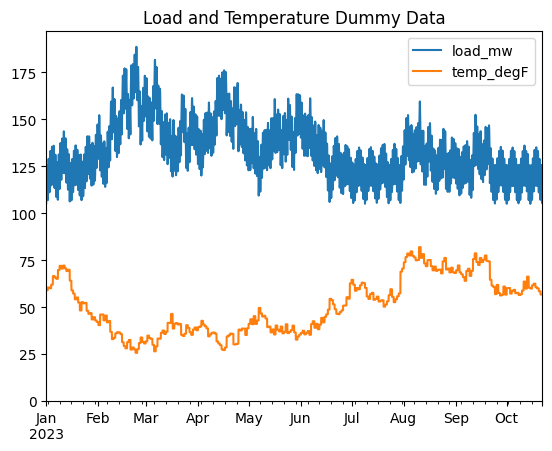

In [144]:
df = generate_dummy_data(n_weeks=42)
df[['load_mw', 'temp_degF']].plot()
plt.ylim(0)
plt.title("Load and Temperature Dummy Data")
df

# Fit a Non-linear Regression Model (XGBoost)

In [145]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score

In [146]:
# Prepare the data
X = df[['temp_degF', 'hour', 'day_of_week']]
y = df['load_mw']

# Split the data into training and testing sets
split_index = int(len(df) * 0.8)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]


Normally we would run this code with different models, hyperparameters, and features to find the best model.  For simplicity, we will use an XGBoost model with default parameters.

In [147]:
# Create and train the XGBoost model
model = xgb.XGBRegressor()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.4f}")
print(f"R-squared Score: {r2:.4f}")


Mean Squared Error: 1.2404
R-squared Score: 0.9864


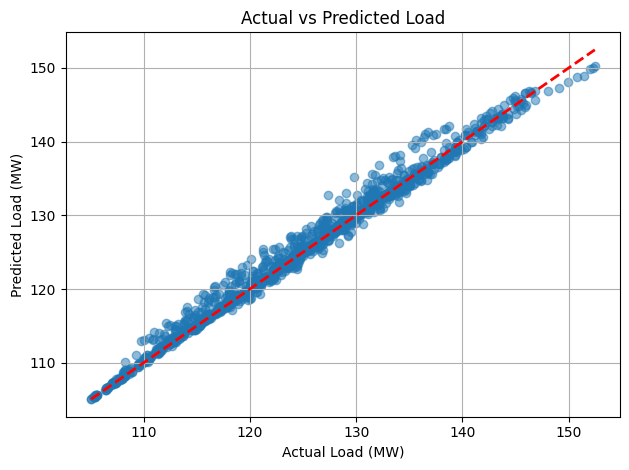

In [148]:
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Actual Load (MW)")
plt.ylabel("Predicted Load (MW)")
plt.title("Actual vs Predicted Load")
plt.tight_layout()
plt.grid()

# Play With Counterfactual What-Ifs

In [149]:
def plot_hourly_pred_actual_ax(df, pred, ax):
    ax.plot(df.index.hour, df['load_mw'], label='actual', marker='+')
    ax.plot(df.index.hour, pred, label='predicted', linestyle=':', marker='+')
    ax.legend()
    ax.set_xlabel('Hour')
    ax.set_ylabel('Load (MW)')
    ax.set_ylim(df['load_mw'].min() - 5, df['load_mw'].max() + 5)
    date = df.index[0].date()
    day = df.index[0].day_name()
    ax.set_title(f'Date: {date}, Day of week: {day}')

In [150]:
# Choose a random day
random_date = df.index[np.random.randint(0, len(df) - 24)].date()
mask = (df.index.date == random_date)
sub_df = df[mask].copy()

(100.0, 170.0)

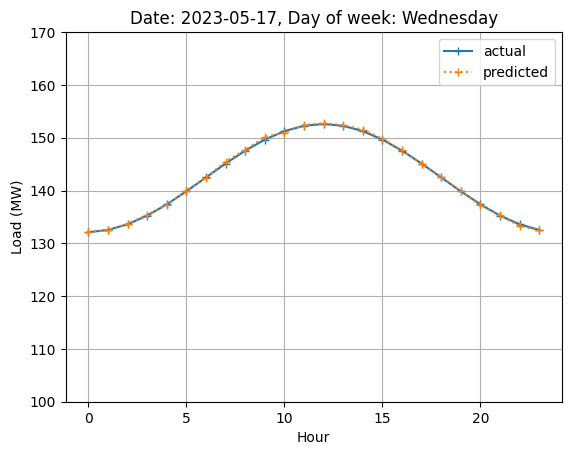

In [152]:
# plot
X = sub_df[['temp_degF', 'hour', 'day_of_week']]
pred = model.predict(X)
fig, ax = plt.subplots()
plot_hourly_pred_actual_ax(sub_df, pred, ax)
plt.grid()
plt.ylim(100, 170)

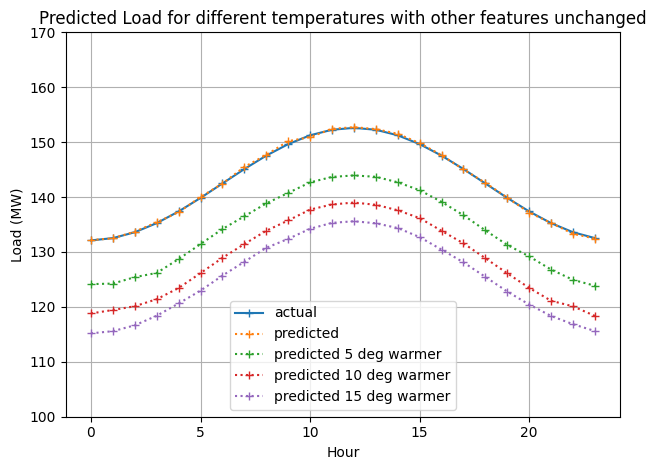

In [153]:
# replot actual and predicted
fig, ax = plt.subplots()
plot_hourly_pred_actual_ax(sub_df, pred, ax)

# Run counterfactuals
temp_changes = [5, 10, 15]
for temp_change in temp_changes:
    X_temp = X.copy()
    X_temp['temp_degF'] += temp_change
    pred_temp = model.predict(X_temp)
    ax.plot(sub_df.index.hour, pred_temp, 
            label=f'predicted {temp_change} deg warmer', 
            linestyle=':', marker='+')

ax.legend()
plt.tight_layout()
ax.set_ylim(100, 170)
plt.title("Predicted Load for different temperatures with other features unchanged")
plt.grid()

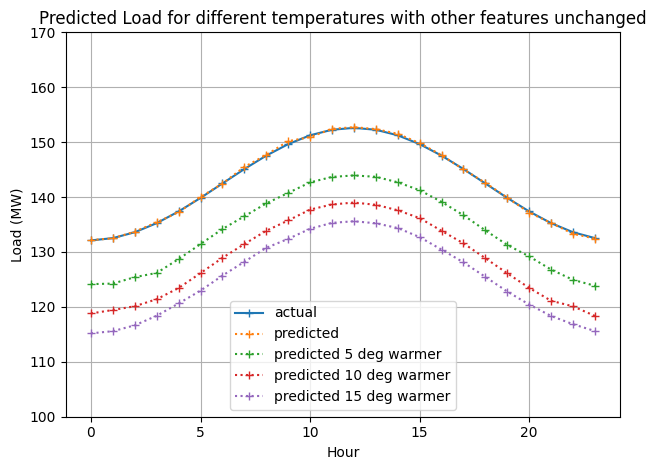

In [154]:
# replot actual and predicted
fig, ax = plt.subplots()
plot_hourly_pred_actual_ax(sub_df, pred, ax)

# Run counterfactuals
temp_changes = [5, 10, 15]
for temp_change in temp_changes:
    X_temp = X.copy()
    X_temp['temp_degF'] += temp_change
    pred_temp = model.predict(X_temp)
    ax.plot(sub_df.index.hour, pred_temp, 
            label=f'predicted {temp_change} deg warmer', 
            linestyle=':', marker='+')

ax.legend()
plt.tight_layout()
ax.set_ylim(100, 170)
plt.title("Predicted Load for different temperatures with other features unchanged")
plt.grid()

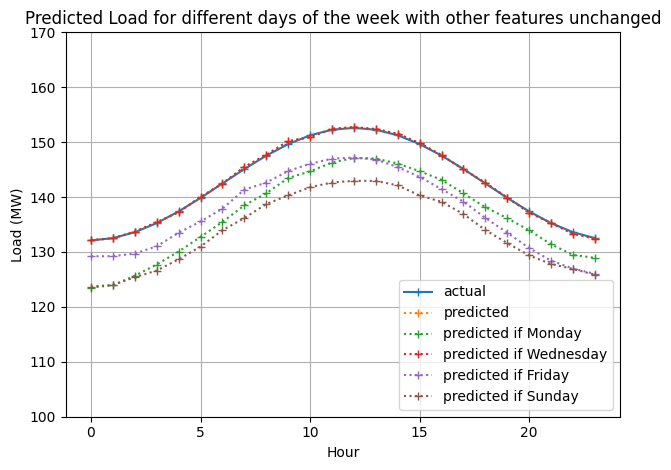

In [155]:
# replot actual and predicted
fig, ax = plt.subplots()
plot_hourly_pred_actual_ax(sub_df, pred, ax)

# Run counterfactuals for different days of the week
days_of_week = [0, 2, 4, 6]  # Monday, Wednesday, Friday, Sunday
day_names = ['Monday', 'Wednesday', 'Friday', 'Sunday']

for day, day_name in zip(days_of_week, day_names):
    X_day = X.copy()
    X_day['day_of_week'] = day
    pred_day = model.predict(X_day)
    ax.plot(sub_df.index.hour, pred_day, 
            label=f'predicted if {day_name}', 
            linestyle=':', marker='+')

ax.legend()
plt.tight_layout()
ax.set_ylim(100, 170)
plt.title("Predicted Load for different days of the week with other features unchanged")
plt.grid()

# Conclusion

While the ML algorithms such as XGBOOST are a black box under the hood, we rapidly predict and plot counterfactual predictions for different inputs that can help us intuitively understand the behavior of the model.  